Note: 387 missing cases have been found in the data set.

Note: 3871824 missing cases have been found in the data set.

Note: 38718241344 missing cases have been found in the data set.

Note: 387182413441404 missing cases have been found in the data set.

Note: 387182413441404900 missing cases have been found in the data set.

Note: 3871824134414049001344 missing cases have been found in the data set.

Note: 3871824134414049001344786 missing cases have been found in the data set.

Note: 38718241344140490013447861053 missing cases have been found in the data set.

Note: 387182413441404900134478610531005 missing cases have been found in the data set.

All missings have been removed.



# A tibble: 3 × 10
  Algorithm  aorta gall_bladder kidney_left kidney_right liver pancreas postcava
  <chr>      <chr> <chr>        <chr>       <chr>        <chr> <chr>    <chr>   
1 MONAI_LHU… 63.0… 71.3 ± 32.2  82.4 ± 27.0 81.8 ± 29.3  87.7… 68.6 ± … 67.5 ± …
2 MONAI_Seg… 60.8… 68.1 ± 29.3  82.6 ± 24.8 82.8 ± 23.5  89.4… 66.3 ± … 63.0 ± …
3 MONAI_Swi… 54.5… 50.6 ± 40.6  58.5 ± 40.2 59.7 ± 39.4  80.2… 42.3 ± … 38.1 ± …
# ℹ 2 more variables: spleen <chr>, stomach <chr>


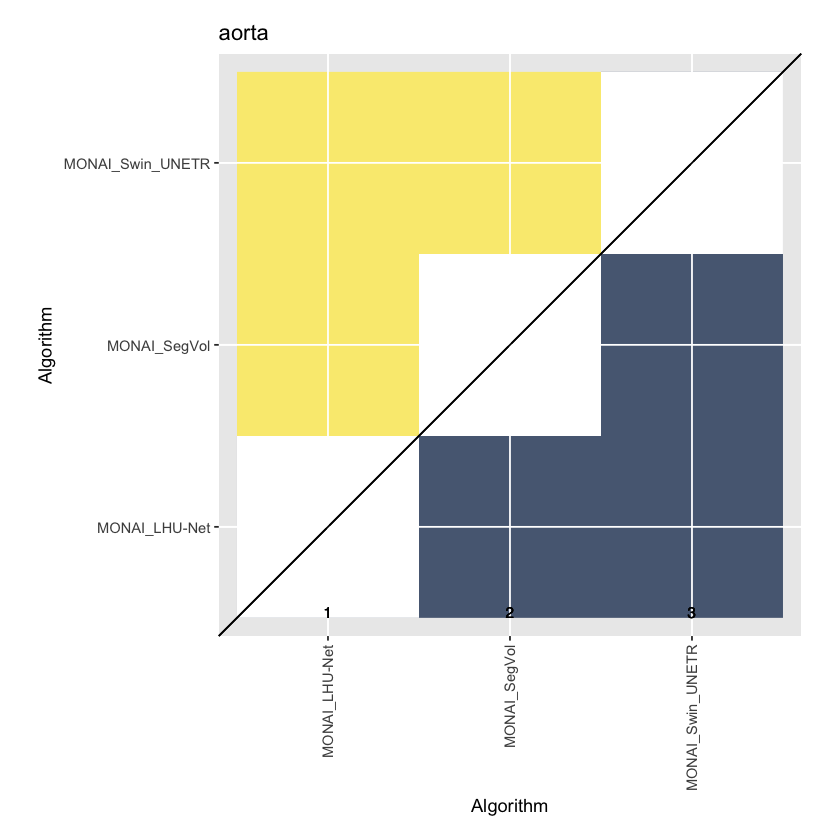

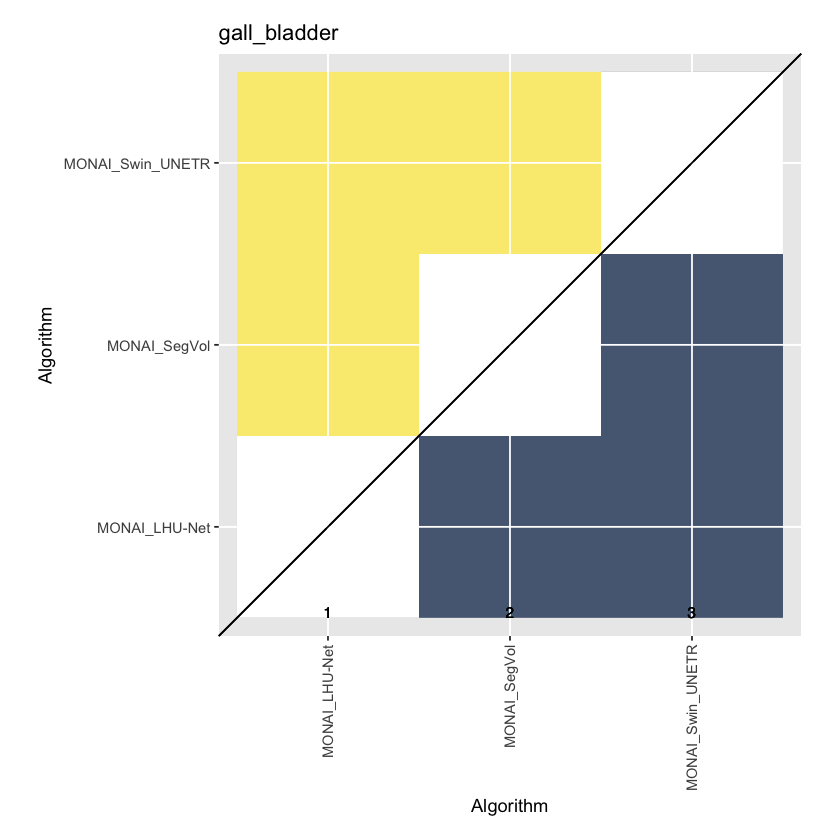

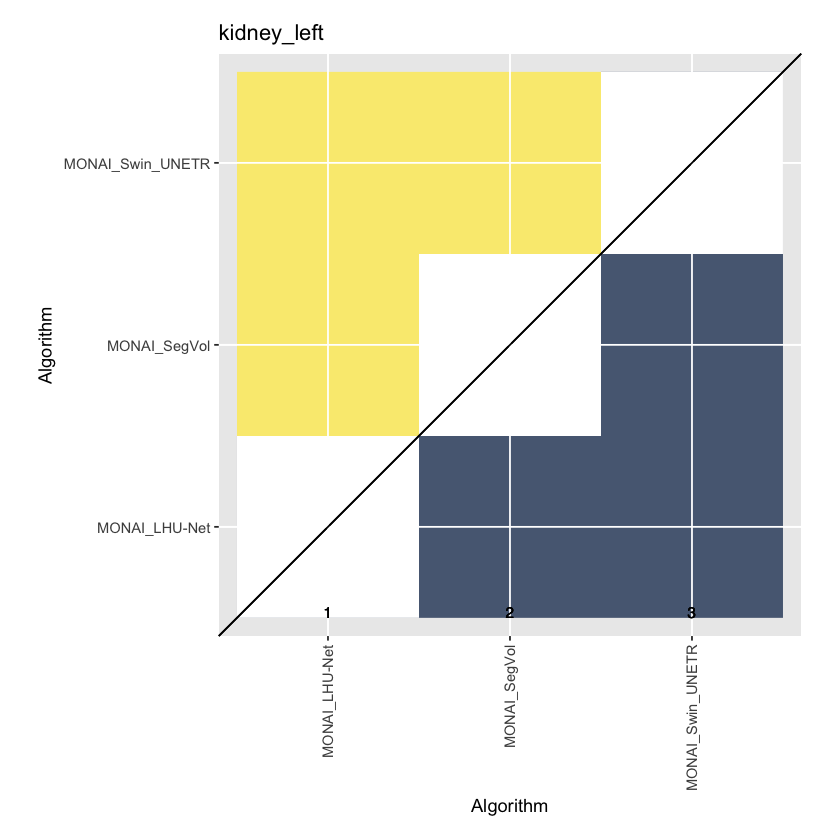

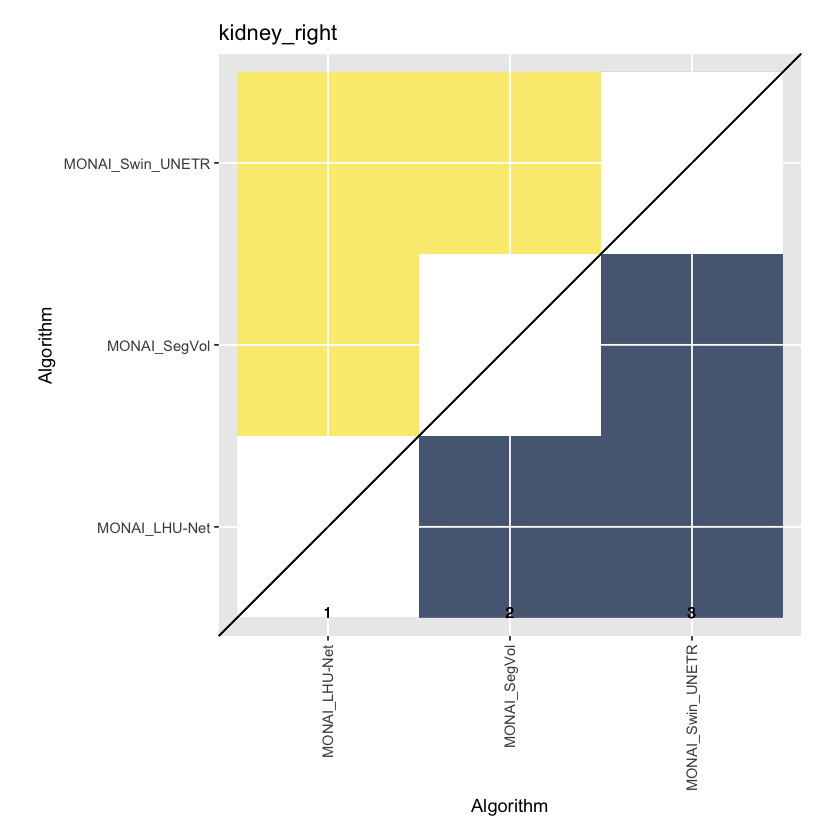

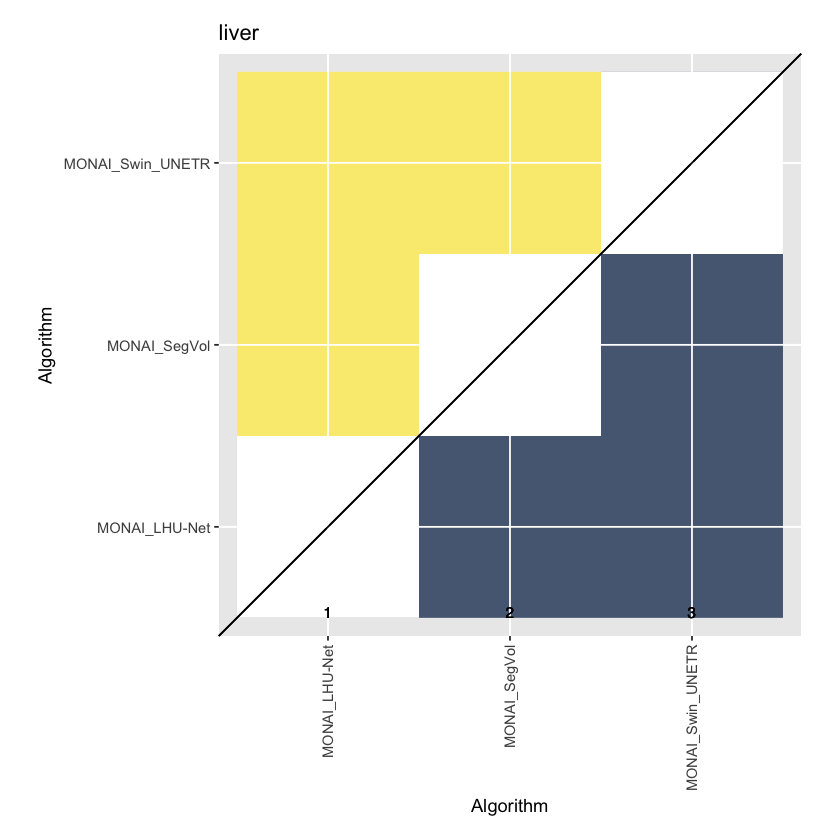

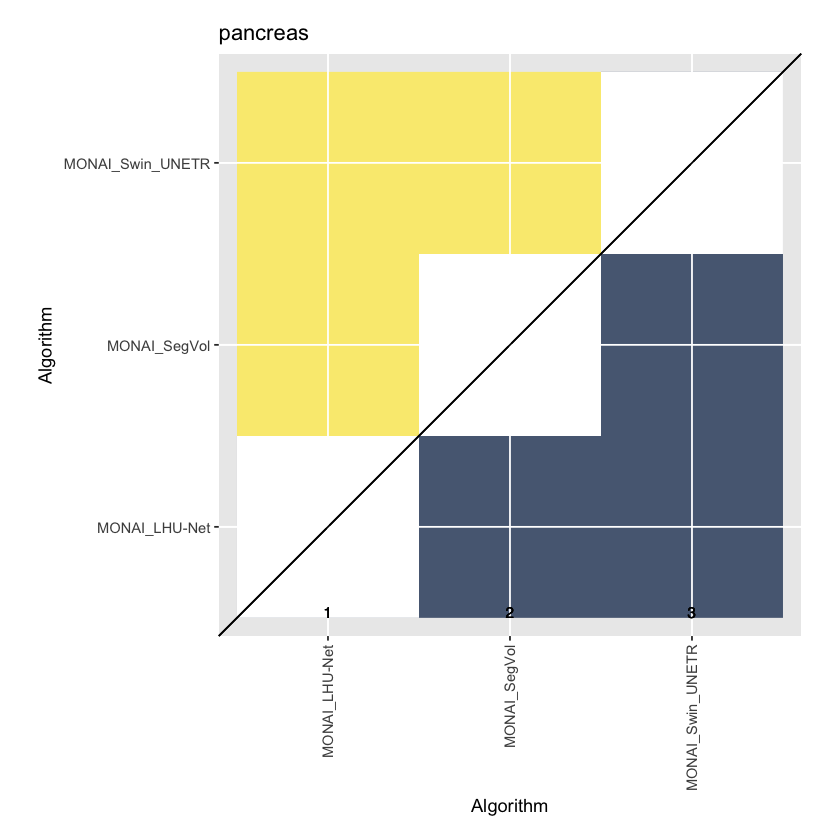

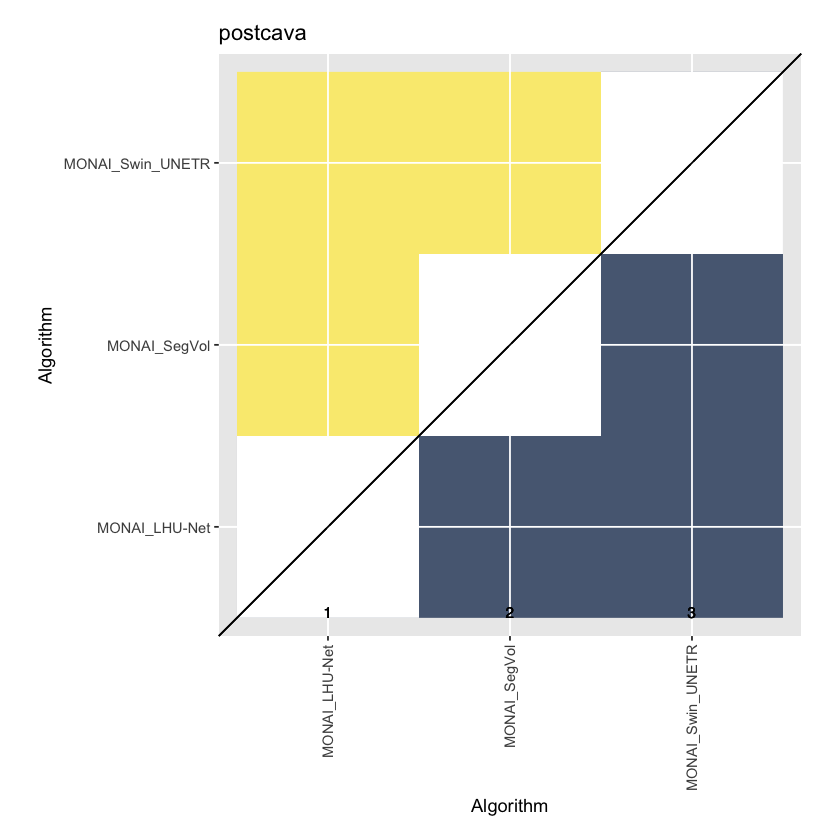

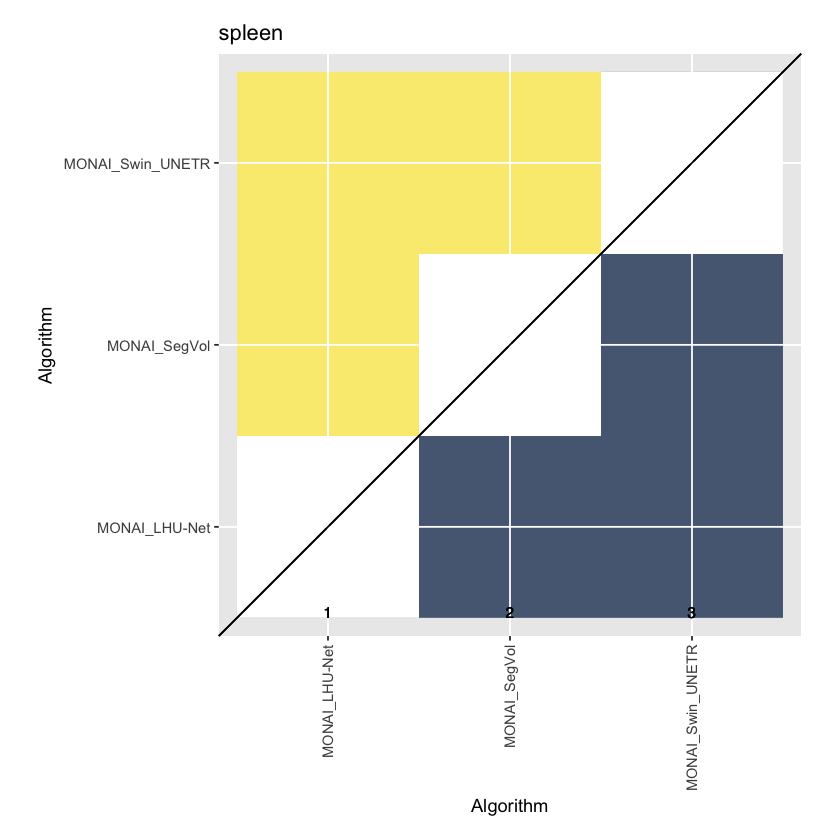

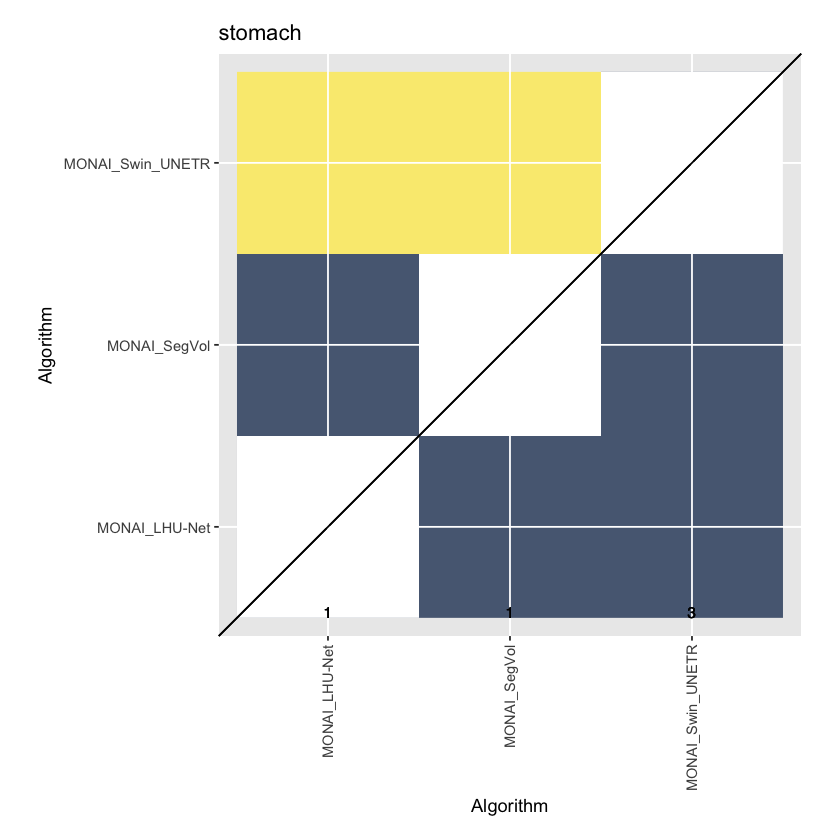

In [3]:
########################################
## 1) Load libraries
########################################
library(dplyr)
library(tidyr)
library(challengeR)

########################################
## 2) Suppose you have a vector of model names and file paths
########################################
model_info <- data.frame(
  model_name = c("MONAI_LHU-Net", "MONAI_SegVol", "MONAI_Swin_UNETR"),
  file_path  = c("totalsegmentator_results/MONAI_LHU-Net/dsc.csv",
                 "totalsegmentator_results/MONAI_SegVol/dsc.csv",
                 "totalsegmentator_results/MONAI_Swin_UNETR/dsc.csv"),
  stringsAsFactors = FALSE
)

########################################
## 3) Read each model's DSC.csv, reshape to long form, and combine
########################################
all_data_long <- data.frame()  # empty to start

for (i in seq_len(nrow(model_info))) {
  this_model <- model_info$model_name[i]
  this_file  <- model_info$file_path[i]
  
  # Read the CSV. Each row = one Case "name", columns are organs
  # Some entries are blank => become NA
  df_wide <- read.csv(this_file, stringsAsFactors = FALSE)
  
  # Pivot longer: now we have columns: name, organ, dsc
  df_long <- df_wide %>%
    pivot_longer(
      cols = -name,
      names_to = "organ",
      values_to = "dsc"
    )
  
  # Tag the algorithm name:
  df_long$Algorithm <- this_model
  
  # Append to the master data.frame:
  all_data_long <- bind_rows(all_data_long, df_long)
}

########################################
## 4) Turn that into a challenge object
########################################
my_challenge <- as.challenge(
  object      = all_data_long,
  case        = "name",
  algorithm   = "Algorithm",
  value       = "dsc",
  by          = "organ",    # each organ is treated as a "task"
  smallBetter = FALSE,      # higher DSC is better
  na.treat    = "na.rm",    # remove rows with NA automatically
  check       = TRUE        # perform sanity checks
)

########################################
## 5) For each organ (task), compute mean and std for each algorithm
########################################
# IMPORTANT: Pass the aggregation function as a character!
mean_obj <- aggregate(my_challenge, FUN = "mean", na.treat = "na.rm")
sd_obj   <- aggregate(my_challenge, FUN = "sd",   na.treat = "na.rm")

########################################
## 6) Combine them into a single table “mean ± sd”
########################################
all_organs <- names(mean_obj$matlist)  # e.g. "aorta", "gall_bladder", etc.

res_table <- data.frame()

for (org in all_organs) {
  df_mean <- mean_obj$matlist[[org]]
  df_sd   <- sd_obj$matlist[[org]]
  
  # Determine the column names produced by aggregate.
  col_mean <- colnames(df_mean)[ncol(df_mean)]
  col_sd   <- colnames(df_sd)[ncol(df_sd)]
  
  tmp <- data.frame(
    Algorithm = rownames(df_mean),
    organ     = org,
    DSC_mean  = df_mean[[ col_mean ]],
    DSC_sd    = df_sd[[ col_sd ]]
  )
  tmp$DSC_string <- sprintf("%.1f ± %.1f", 100 * tmp$DSC_mean, 100 * tmp$DSC_sd)
  
  res_table <- rbind(res_table, tmp)
}

library(tidyr)
final_table <- res_table %>%
  select(Algorithm, organ, DSC_string) %>%
  pivot_wider(
    names_from  = organ,
    values_from = DSC_string
  ) %>%
  arrange(Algorithm)

########################################
## 7) Inspect final_table
########################################
print(final_table)

########################################
## 8) (Optional) Significance testing and map
########################################
sig_obj <- aggregate(my_challenge, FUN = "significance", alpha = 0.05,
                     p.adjust.method = "holm")
my_ranked <- rank(sig_obj)
significanceMap(my_ranked)


In [ ]:
##############################################
## 0) Required packages
##############################################
library(dplyr)
library(tidyr)
library(challengeR)
library(ggplot2)   # for any final patchwork usage or theme
# Optionally: library(patchwork) or cowplot, if you want to combine subplots

##############################################
## 1) List all subfolders that contain DSC files
##############################################
# Suppose your structure is "totalsegmentator_results/NAME_OF_MODEL/dsc.csv".
# We'll get a list of subdirectories that contain "dsc.csv".
base_dir <- "totalsegmentator_results"

# A simple approach: get all subfolders, keep those with "dsc.csv"
all_subdirs <- list.dirs(base_dir, full.names = TRUE, recursive = FALSE)

# For each subdir, check if "dsc.csv" exists
model_info <- data.frame()
for (subdir in all_subdirs) {
  dsc_path <- file.path(subdir, "dsc.csv")
  if (file.exists(dsc_path)) {
    model_name <- basename(subdir)  # e.g. "nnU-Net_U-Net", "MONAI_LHU-Net", etc.
    model_info <- rbind(model_info, 
                        data.frame(model_name = model_name,
                                   file_path  = dsc_path,
                                   stringsAsFactors = FALSE))
  }
}
# 'model_info' now has columns: model_name, file_path

##############################################
## 2) Read each model's DSC.csv, pivot longer
##############################################
all_data_long <- data.frame()

for (i in seq_len(nrow(model_info))) {
  this_model <- model_info$model_name[i]
  this_file  <- model_info$file_path[i]
  
  # read CSV => each row is one 'name' (case), columns are organs
  df_wide <- read.csv(this_file, stringsAsFactors = FALSE)
  
  # pivot longer => columns: name, organ, dsc
  df_long <- df_wide %>%
    pivot_longer(
      cols = -name,    # pivot all columns except "name"
      names_to = "organ",
      values_to = "dsc"
    )
  # Label the algorithm
  df_long$Algorithm <- this_model
  
  # combine
  all_data_long <- bind_rows(all_data_long, df_long)
}

##############################################
## 3) Build a challenge object
##############################################
my_challenge <- as.challenge(
  object      = all_data_long,
  case        = "name",       # the column identifying each scan
  algorithm   = "Algorithm",  # the column labeling each model
  value       = "dsc",        # the DSC column
  by          = "organ",      # treat each 'organ' as a separate "task"
  smallBetter = FALSE,        # larger DSC is better
  na.treat    = "na.rm",      # drop NA entries
  check       = TRUE
)

##############################################
## 4) Convert to a ranked format
##############################################
# For boxplots in challengeR we can do either:
#  -- boxplot() on a "ranked.list" object
#  -- or boxplot() on the raw "challenge" object (which internally calls rank).
#
# Typically you'd do rank(...) first so challengeR knows the order of algorithms.
# ties.method="min" is typical, but you can pick "average", etc.
##############################################
my_ranked <- rank(my_challenge, ties.method = "min")

##############################################
## 5) Produce the boxplots
##############################################
# The function boxplot.ranked.list(...) returns a list of ggplots, one per organ
# with both dot/jitter and box‐and‐whiskers. By default they share a single color legend.
# You can do something like:
##############################################
plot_list <- boxplot(my_ranked,
                     jitter.width = 0.3)  # can tweak

# This returns a list of ggplot objects, one for each organ.
# If you just have 1 or 2 organs, printing them individually is easy:
# e.g. print(plot_list[["liver"]]) or something.

# If you have many organs, you can arrange them in a grid with patchwork or cowplot:
# For example, if you want them all in one PDF:
pdf("JHH_Boxplots_AllOrgans.pdf", width=10, height=8)
for (plt in plot_list) {
  print(plt)
  # or you can do e.g. patchwork::wrap_plots(plot_list) if you prefer a single page
}
dev.off()

##############################################
## 6) That’s it! 
##############################################
# Now you have a set of boxplots (one per organ). 
# Each boxplot shows a dot swarm + box, colored by 'Algorithm'.
# This is similar to the "Figure 15" style from the paper (distribution of DSC across each organ).


case,value,algo
<chr>,<dbl>,<chr>
s0000,NA,_Diff-UNet
s0001,0.9701754,_Diff-UNet
s0002,NA,_Diff-UNet
s0003,NA,_Diff-UNet
s0006,0.9780747,_Diff-UNet
s0009,0.9807968,_Diff-UNet


Note: 5624 missing cases have been found in the data set.

Performance of not all algorithms has been observed for all cases.
Therefore, missings have been inserted in the following cases:



                 algo  case
1   nnU-Net_STU-Net_H s0001
2   nnU-Net_STU-Net_H s0048
3   nnU-Net_STU-Net_H s0061
4   nnU-Net_STU-Net_H s0062
5   nnU-Net_STU-Net_H s0066
6   nnU-Net_STU-Net_H s0067
7   nnU-Net_STU-Net_H s0079
8   nnU-Net_STU-Net_H s0112
9   nnU-Net_STU-Net_H s0114
10  nnU-Net_STU-Net_H s0117
11  nnU-Net_STU-Net_H s0130
12  nnU-Net_STU-Net_H s0146
13  nnU-Net_STU-Net_H s0154
14  nnU-Net_STU-Net_H s0169
15  nnU-Net_STU-Net_H s0209
16  nnU-Net_STU-Net_H s0226
17  nnU-Net_STU-Net_H s0235
18  nnU-Net_STU-Net_H s0242
19  nnU-Net_STU-Net_H s0254
20  nnU-Net_STU-Net_H s0301
21  nnU-Net_STU-Net_H s0311
22  nnU-Net_STU-Net_H s0326
23  nnU-Net_STU-Net_H s0353
24  nnU-Net_STU-Net_H s0361
25  nnU-Net_STU-Net_H s0386
26  nnU-Net_STU-Net_H s0436
27  nnU-Net_STU-Net_H s0457
28  nnU-Net_STU-Net_H s0504
29  nnU-Net_STU-Net_H s0526
30  nnU-Net_STU-Net_H s0527
31  nnU-Net_STU-Net_H s0552
32  nnU-Net_STU-Net_H s0557
33  nnU-Net_STU-Net_H s0559
34  nnU-Net_STU-Net_H s0561
35  nnU-Net_STU-Net_

All missings have been removed.



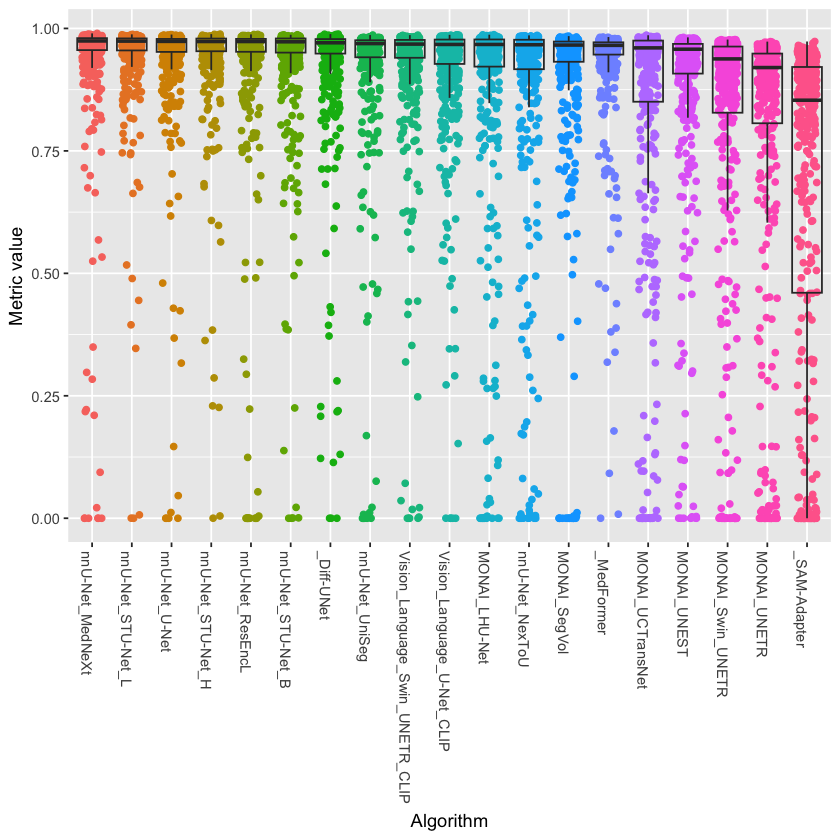

In [7]:
# ------------------------------------------------------
# 0. Packages
# ------------------------------------------------------
library(challengeR)
library(dplyr)
library(purrr)   # for map_dfr()
library(readr)

# ------------------------------------------------------
# 1. Gather "liver" DSC from all model dirs
# ------------------------------------------------------
parent_dir <- "./totalsegmentator_results"

# List the immediate subdirectories in parent_dir:
model_dirs <- list.dirs(parent_dir, recursive = FALSE)

df_all <- map_dfr(model_dirs, function(mdir) {
  csv_file <- file.path(mdir, "dsc.csv")
  if (!file.exists(csv_file)) {
    message("Skipping directory: no dsc.csv in ", mdir)
    return(NULL)
  }
  
  # read the CSV.  The columns include name, aorta, gall_bladder, kidney_left, etc.
  # If they are empty columns, that is okay; they will be read as NA
  tmp <- read_csv(csv_file, show_col_types = FALSE)
  
  # We only want "name" + "liver" from this CSV
  # Note: the columns must exist, so check your CSV exactly
  tmp <- tmp %>%
    select(name, liver)
  
  # rename so that challengeR sees them as "case" and "value"
  tmp <- tmp %>%
    rename(case = name,  # 'name' column => 'case'
           value = liver # 'liver' column => 'value'
    )
  
  # add the "algo" (algorithm) column = subdirectory name
  tmp <- tmp %>%
    mutate(algo = basename(mdir))
  
  return(tmp)
})

# Inspect the combined data frame
head(df_all)
#  case    value     algo
#  s0001   0.936...  MONAI_UNETR
#  s0002   NA        MONAI_UNETR
#  ...

# ------------------------------------------------------
# 2. Construct a challenge object (single-task, for organ 'liver')
# ------------------------------------------------------
chal <- as.challenge(
  df_all,
  algorithm = "algo",   # we just created the 'algo' col
  case      = "case",   # from 'name'
  value     = "value",  # from 'liver'
  taskName  = "liver",  # let’s label the single task "liver"
  smallBetter = FALSE,   # DSC => bigger is better
    na.treat    = "na.rm",    # remove rows with NA automatically
)

# ------------------------------------------------------
# 3. For instance, do an aggregate-then-rank
# ------------------------------------------------------
ranking <- chal %>%
  aggregateThenRank(FUN = median, ties.method = "min")

# ------------------------------------------------------
# 4. Make boxplot
# ------------------------------------------------------
box_fig <- boxplot(ranking)   # single figure with boxplots
box_fig

# If you want to save it:
# ggsave("liver_boxplot.pdf", box_fig, width=6, height=4)
